Catatan: Sebelum menjalankan ganti runtime menggunakan GPU.

```
# This is formatted as code
```


Caranya:
klik Runtime --> Change runtime type --> Hardware accelerator -->GPU kemudian klik Save

## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
#from keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

## Load the Dataset

In [ ]:
#Untuk dataset langsung di enviroment kaggle
#TRAIN_DIR = '../input/facial-expression-dataset/train/train/'
#TEST_DIR = '../input/facial-expression-dataset/test/test/'

In [ ]:
#jika dataset dalam folder google drive
#TRAIN_DIR = '/content/drive/My Drive/CNN/dataset/facial_emotion/train/'  #harus disesuaikan direktori drive anda
#TEST_DIR = '/content/test/test/'



In [ ]:
from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Gunakan Load the Dataset di tahap ini, sebelumnya download dan upload dulu dataset
https://www.kaggle.com/datasets/chiragsoni/ferdata?resource=download

In [2]:
#dirunning ketika akan unzip file yang ada di temporary
!unzip archive.zip #sesuaikan dengan nama filenya

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [3]:
#Jika dataset dalam folder temporary
TRAIN_DIR = '/content/train/'
TEST_DIR = '/content/test/'


In [4]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

In [5]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()


angry Completed
disgust Completed
happy Completed
fear Completed
neutral Completed
surprise Completed
sad Completed


,image,label
0,/content/train/sad/Training_35411957.jpg,sad
1,/content/train/surprise/Training_15146606.jpg,surprise
2,/content/train/fear/Training_43909880.jpg,fear
3,/content/train/neutral/Training_29212833.jpg,neutral
4,/content/train/happy/Training_40630936.jpg,happy


In [6]:
len(train)

28709

In [7]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

angry Completed
disgust Completed
happy Completed
fear Completed
neutral Completed
surprise Completed
sad Completed


,image,label
0,/content/test/angry/PublicTest_44227970.jpg,angry
1,/content/test/angry/PublicTest_67146017.jpg,angry
2,/content/test/angry/PublicTest_25092940.jpg,angry
3,/content/test/angry/PublicTest_40824482.jpg,angry
4,/content/test/angry/PrivateTest_69615683.jpg,angry


In [8]:
len(test)

7178

## Exploratory Data Analysis

<Axes: xlabel='label', ylabel='count'>

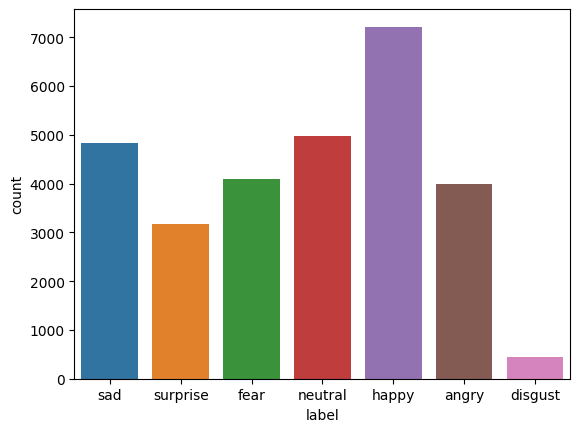

In [9]:
sns.countplot(x=train["label"])

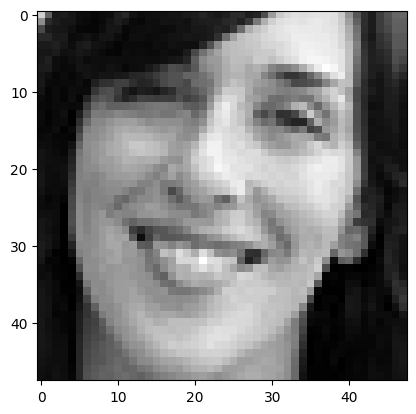

In [10]:
from PIL import Image
img = Image.open(train['image'][15])
plt.imshow(img, cmap='gray');

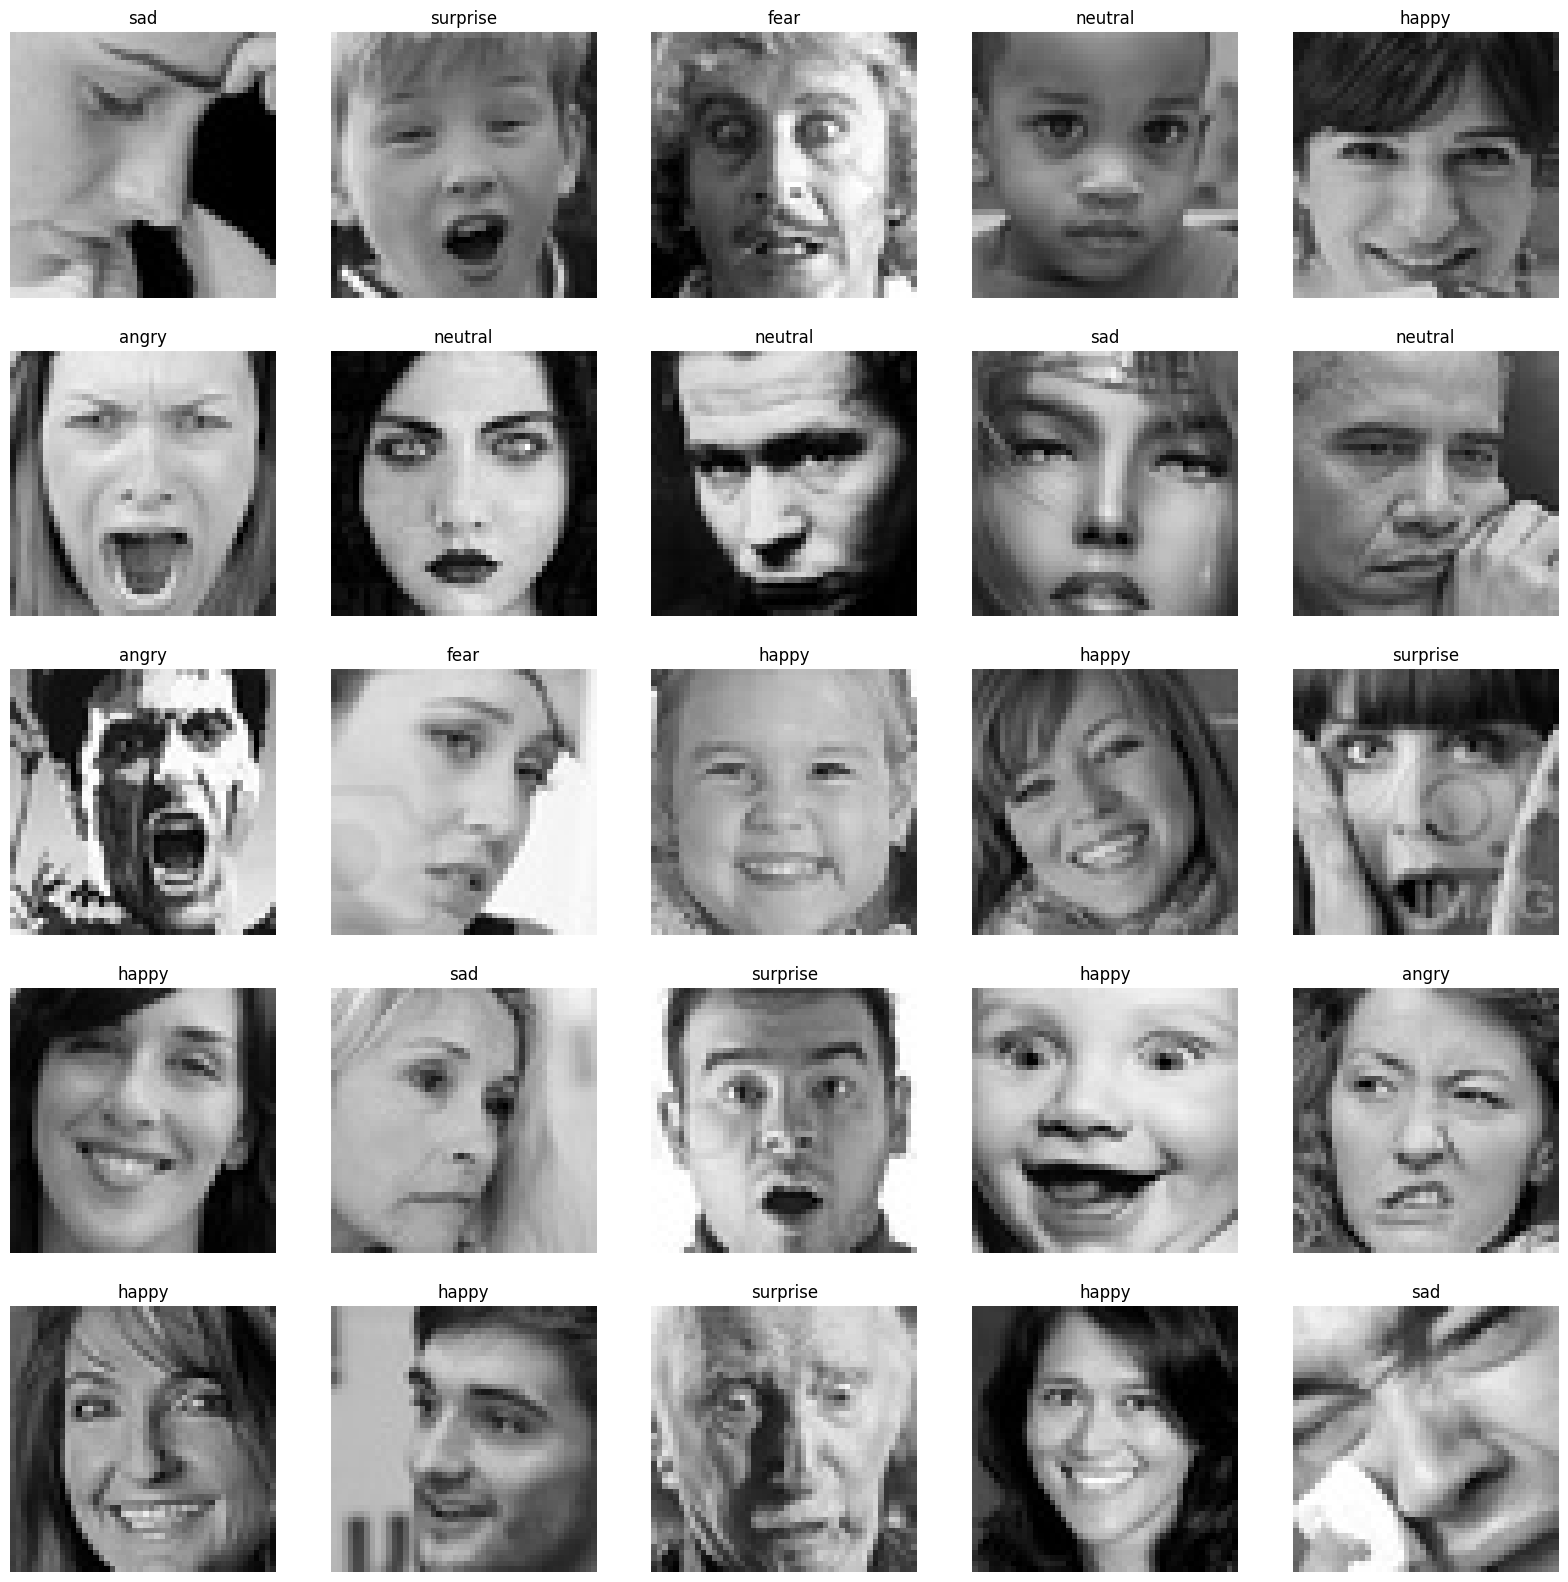

In [11]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [12]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [13]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [14]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [15]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [16]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [17]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [18]:
y_train[10]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [19]:
# config
input_shape = (48, 48, 1)
output_class = 7

## Model Creation

In [20]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 256)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 256)       0

In [21]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))
#mempercepat train
#history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
225/225 [==============================] - 21s 57ms/step - loss: 1.8231 - accuracy: 0.2487 - val_loss: 1.8102 - val_accuracy: 0.2471
Epoch 2/10
225/225 [==============================] - 11s 49ms/step - loss: 1.7906 - accuracy: 0.2580 - val_loss: 1.7406 - val_accuracy: 0.2980
Epoch 3/10
225/225 [==============================] - 11s 49ms/step - loss: 1.6824 - accuracy: 0.3196 - val_loss: 1.5325 - val_accuracy: 0.3870
Epoch 4/10
225/225 [==============================] - 11s 49ms/step - loss: 1.5388 - accuracy: 0.3979 - val_loss: 1.4297 - val_accuracy: 0.4469
Epoch 5/10
225/225 [==============================] - 11s 49ms/step - loss: 1.4507 - accuracy: 0.4402 - val_loss: 1.3640 - val_accuracy: 0.4663
Epoch 6/10
225/225 [==============================] - 11s 49ms/step - loss: 1.4081 - accuracy: 0.4599 - val_loss: 1.2916 - val_accuracy: 0.5031
Epoch 7/10
225/225 [==============================] - 11s 49ms/step - loss: 1.3656 - accuracy: 0.4778 - val_loss: 1.2653 - val_accuracy:

## Save model

In [22]:
path_model='model_CNN_facial_emotion.h5'
path_bobot='bobot_CNN_facial_emotion'
model.save(path_model)
model.save_weights(path_bobot)

In [ ]:
'''
from tensorflow.keras.models import load_model
savedModel=load_model(path_model)
savedModel.summary()
savedModel = savedModel.load_weights(path_bobot)
'''

## Load Model

In [24]:
from keras.models import load_model
emotion_model = load_model('/content/model_CNN_facial_emotion.h5/')

## Plot the Results

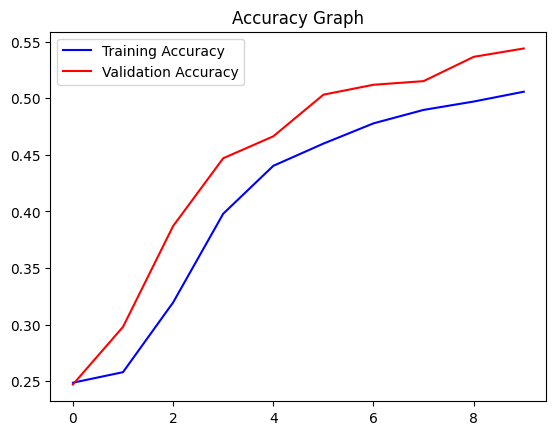

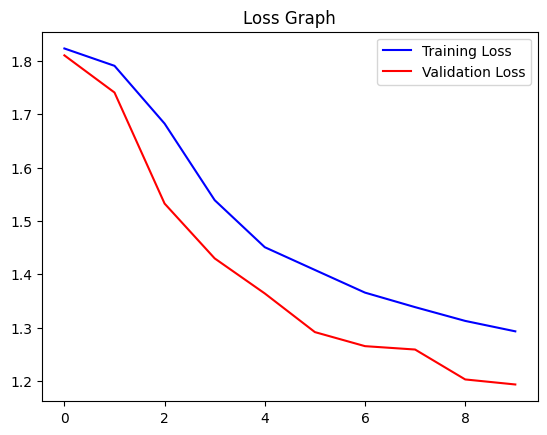

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Test with Image Data

Original Output: neutral
1/1 [==============================] - 0s 398ms/step
Predicted Output: sad


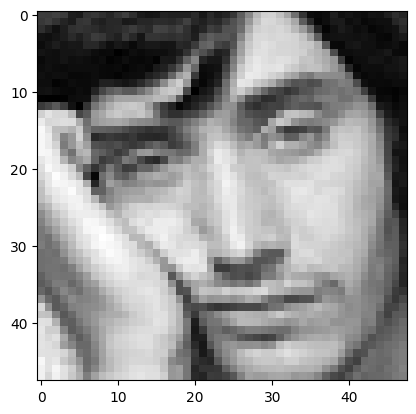

In [26]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: happy
1/1 [==============================] - 0s 19ms/step
Predicted Output: happy


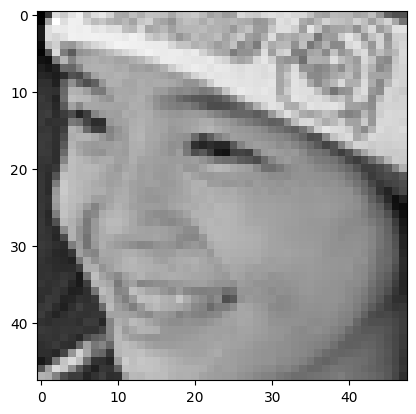

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

In [27]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))

    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')

    plt.show()

In [28]:
#CODE for Capturing an image on Colab from here: https://colab.research.google.com/notebook#fileId=1OnUy6eFE7XhdfGfAHDCqQxpwueTOj_NO

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [29]:
take_photo()

<IPython.core.display.Javascript object>

'photo.jpg'

OpenCV(4.8.0) /io/opencv/modules/objdetect/src/cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'detectMultiScale'

1/1 [==============================] - 0s 82ms/step


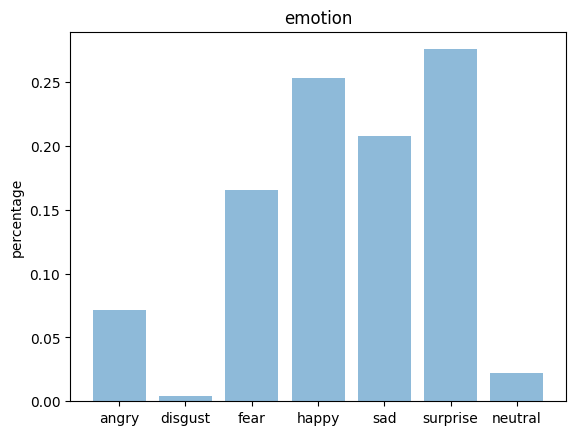

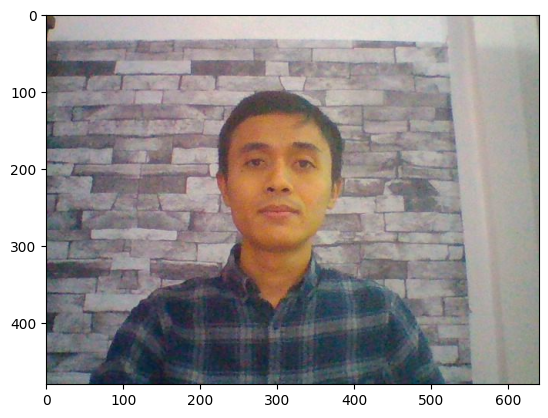

In [30]:
import cv2

def facecrop(image):
    facedata = '/content/haarcascade_frontalface_alt.xml'
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:

        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]


            cv2.imwrite('capture.jpg', sub_face)
            #print ("Writing: " + image)

    except Exception as e:
        print (e)




if __name__ == '__main__':
    facecrop('/content/photo.jpg')

#Testing a file.
import tensorflow.compat.v2 as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
#import tf.keras.preprocessing.image.load_img


file = '/content/photo.jpg'
#true_image = image.load_img(file)
true_image = tf.keras.utils.load_img(file)

#img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

img = tf.keras.utils.load_img(file, color_mode="grayscale", target_size=(48, 48))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = emotion_model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);


plt.imshow(true_image)
plt.show()

OpenCV(4.8.0) /io/opencv/modules/objdetect/src/cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'detectMultiScale'



Saving contoh foto anak1.jpg to contoh foto anak1.jpg
1/1 [==============================] - 0s 26ms/step


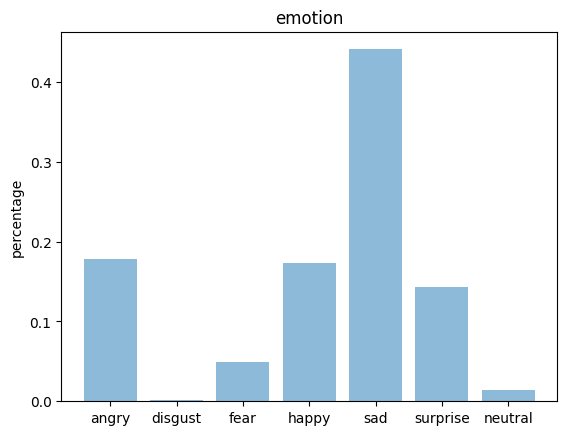

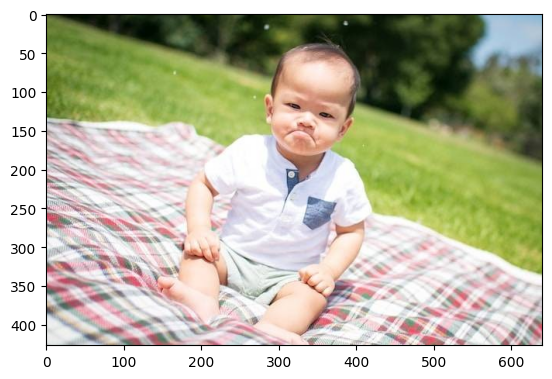

In [ ]:
import cv2

def facecrop(image):
    facedata = '/content/haarcascade_frontalface_alt.xml'
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:

        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]


            cv2.imwrite('capture.jpg', sub_face)
            #print ("Writing: " + image)

    except Exception as e:
        print (e)




if __name__ == '__main__':
    facecrop('/content/photo.jpg')

#Testing a file.
import tensorflow.compat.v2 as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
#import tf.keras.preprocessing.image.load_img

from google.colab import files


uploaded = files.upload()

for fn in uploaded.keys():

   # path = fn
      file = fn
#true_image = image.load_img(file)
true_image = tf.keras.utils.load_img(file)

#img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

img = tf.keras.utils.load_img(file, color_mode="grayscale", target_size=(48, 48))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = emotion_model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);


plt.imshow(true_image)
plt.show()